In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import interpolate, signal

from tqdm.notebook import tqdm, trange
from tqdm.keras import TqdmCallback

import pathlib, sys, os
from os import *

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (precision_recall_curve, classification_report, confusion_matrix,accuracy_score,
                             precision_score, recall_score, f1_score,roc_auc_score, auc)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import KFold
plt.style.use('classic')
plt.rcParams['figure.figsize'] = (8,4)
plt.rcParams['axes.grid'] = True

# Connect to Google Drive


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# conect_google= True

In [40]:
conect_google=  False
if conect_google== True:
  #path= pd.read_excel('/content/drive/MyDrive/מחקר תזה/gait detection.xlsx')

  path= '/content/drive/MyDrive/מחקר תזה/'
  excelometer_files = '/content/drive/MyDrive/מחקר תזה/CSV file'
else:
  path= 'G:/האחסון שלי/מחקר תזה/'
  excelometer_files = path+'CSV file/'
folder_path = path+'CSV file'
gait_detection= pd.read_excel(path+'gait detection.xlsx')
selected_columns = ['Subject', 'Age',	'Gender',	'height',	'weight', 'vig', 'mod',	'walk',	'IPAQ-total physical activity',	'IPAQ-time spent sitting',	'BriefBESTest']

df= gait_detection[selected_columns]
df['bmi']= df['weight']/(((df['height'])/100)**2)
df.rename(columns={'IPAQ-total physical activity': 'IPAQ_activity', 'IPAQ-time spent sitting': 'IPAQ_sitting'}, inplace=True)
df['Gender'] = df['Gender'].map({'M': 1, 'F': 2})
df['Subject']= df['Subject'].astype(str)


סידור הקבצים מאורי לתיקייה אחת

In [ ]:
# import os
# import shutil

# source_path = path+'data/'
# destination_path = path+'data_new'

# # Ensure the destination directory exists
# if not os.path.exists(destination_path):
#     os.makedirs(destination_path)

# # Loop through all subdirectories in the source path
# for folder_name in os.listdir(source_path):
#     folder_path = os.path.join(source_path, folder_name)

#     # Check if it's a directory
#     if os.path.isdir(folder_path):
#         file_path = os.path.join(folder_path, 'd.csv')

#         # Check if the file exists
#         if os.path.exists(file_path):
#             new_file_path = os.path.join(destination_path, f'{folder_name}.csv')

#             # Copy and rename the file
#             shutil.copy(file_path, new_file_path)
#             print(f'Copied: {file_path} to {new_file_path}')


In [41]:
data_uri= pd.read_excel(path+'ages.xlsx')
data_uri['Subject']= data_uri['Subject'].astype(str)
data_uri['Gender'] = data_uri['Gender'].map({'M': 1, 'F': 2})

folder_path_uri = path+'data_uri'
file_paths_uri = [os.path.join(folder_path_uri,"/" +  f) for f in os.listdir(folder_path_uri)]
# Get a list of full file paths in the folder with a forward slash before each file name
if conect_google== True:
  file_paths_uri  = [f[1:-4] for f in file_paths_uri]
else:
  file_paths_uri  = [f[3:-4] for f in file_paths_uri]

data_uri = data_uri[data_uri['Subject'].isin(file_paths_uri)]
data_uri.reset_index(inplace= True)
data_uri.drop('index',axis= 1, inplace= True)

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def fetch_uri(subjects, df, freq=128, n_seconds=3, train=False):
    """
    A function to read subjects accelerometer data.

    params:
        subjects : a list of subjects folders
        freq     : the sampling frequency all signals will be converted to
        n_seconds: number of seconds to fetch from each signal
        train    : if true, fetches two n_seconds signals from each recording, as data augmentation. default: False

    """

    output = pd.DataFrame()  # output dataframe
    num_index = 0  # Initialize num_index outside the loop
    # for each subject, try to read accelerometer data
    for s in tqdm(subjects):
        try:
            data = pd.read_csv(s + '.csv')
            data.columns = ['time', 'x', 'y', 'z', 't']
        except:
            print(s, ':\t', sys.exc_info()[0])
            continue

        # remove very short recordings
        if data['time'].max() < 12:
            print(f'Too short dataset {s}: {data["time"].max()}')
            continue

        # data cleaning: if accelerometer is turned off, remove following data.
        off_phase = np.where(np.diff(data.time) > 1)[0]
        if off_phase.shape[0] > 0:
            data = data.loc[:off_phase[0]]

        # calculate sampling frequency for each subject
        fs = data.time.idxmax() / data.time.max()

        data.set_index('time', inplace=True)

        # take n_seconds measurements. we take n_seconds around the first quarter, as the middle point is
        # often when the person turned back.
        if train:
            n_seconds *= 2
        middle = data.index.max() / 4
        start = middle - n_seconds / 2
        end = middle + n_seconds / 2
        data = data[(data.index > start) & (data.index < end)]

        # up/down sample to <freq> hz
        x = data.index
        xnew = np.linspace(min(x), max(x), freq * n_seconds)
        for c in data.columns:
            y = data[c]
            f = interpolate.interp1d(x, y, bounds_error=False, fill_value="extrapolate")
            ynew = f(xnew)
            temp = pd.DataFrame(ynew.reshape(1, -1))

            temp['Subject'] = df.iloc[num_index]['Subject']
            temp['Axis'] = c
            output = pd.concat([output, temp], ignore_index=True)
            #output = output.append(temp, ignore_index=True)

        num_index += 1  # Increment num_index for each subject

    # Merge with additional information from df
    output = output.merge(df, how='left', on='Subject')

    # Reorder columns
    output = output[['Subject', 'Age','Gender', 'Axis'] + list(range(freq * n_seconds))]

    return output

    # call the fetch function to read data
n_seconds = 8
newfreq = 100
subjects = data_uri['Subject']
folder = [path+'data_new/'+str(c) for c in subjects.values]

data_uri = fetch_uri(folder,data_uri, freq = newfreq, n_seconds = n_seconds)


#עמודה ראשונה השלמת ערכים חסרים

data_uri.iloc[:, 4] = data_uri.iloc[:, 4].fillna(data_uri.iloc[:, 5])

handcrafted_features = pd.DataFrame()
signal_col = data_uri.iloc[:, 4:]
# Maximum
handcrafted_features['maximum'] = signal_col.max(axis=1)

# Minimum
handcrafted_features['minimum'] =signal_col.min(axis=1)

# Average
handcrafted_features['average'] = signal_col.mean(axis=1)

# Standard deviation
handcrafted_features['std'] = signal_col.std(axis=1)

# Zero crossing
def zero_crossings(values):
    count = 0
    prev_value = values[0]

    # Iterate over the values starting from the second value
    for value in values[1:]:
        # Check if the sign of the current value is different from the previous value
        if prev_value * value < 0:
            count += 1  # Increment the count if there is a zero crossing
        prev_value = value  # Update the previous value for the next iteration

    return count
handcrafted_features['zero_crossings'] = signal_col.apply(zero_crossings, axis=1)

# Percentiles
handcrafted_features['percentile_20'] =signal_col.quantile(0.20, axis=1)
handcrafted_features['percentile_50'] = signal_col.quantile(0.50, axis=1)
handcrafted_features['percentile_80'] = signal_col.quantile(0.80, axis=1)

# Interquartile range
handcrafted_features['interquartile_range'] = signal_col.quantile(0.75, axis=1) - data_uri.iloc[:, 4:804].quantile(0.25, axis=1)

# Kurtosis
handcrafted_features['kurtosis'] = signal_col.kurtosis(axis=1)

# Skewness   𝑠𝑘𝑒𝑤𝑛𝑒𝑠𝑠(𝑀)= 𝜇˜**3= ∑𝑛𝑖=1(𝑚𝑖−𝜇)**3/𝑛𝜎3
handcrafted_features['skewness'] =signal_col.skew(axis=1)

# Order mean values
def order_mean_values(row):
    sorted_row = np.sort(row)  # Sort the row in ascending order
    fom = sorted_row[0]  # First-order statistic (smallest value)
    som = np.mean(sorted_row[:2])  # Second-order statistic (mean of the two smallest values)
    som = np.reshape(som, (1,))  # Reshape som into a 1D array

    # Compute norms
    norm_fom_l1 = np.linalg.norm(sorted_row, ord=1)  # L1 norm of FOM
    norm_fom_l2 = np.linalg.norm(sorted_row, ord=2)  # L2 norm of FOM
    norm_som_l1 = np.linalg.norm(som, ord=1)  # L1 norm of SOM
    norm_som_l2 = np.linalg.norm(som, ord=2)  # L2 norm of SOM
    som = np.mean(sorted_row[:2])  # Second-order statistic (mean of the two smallest values)
    som = np.reshape(som, (1,))[0]
    return [fom, som, norm_fom_l1, norm_fom_l2, norm_som_l1, norm_som_l2]

handcrafted_features[['FOM', 'SOM', 'Norm_FOM_L1', 'Norm_FOM_L2', 'Norm_SOM_L1', 'Norm_SOM_L2']] = signal_col.apply(order_mean_values, axis=1, result_type='expand')

# Spectral entropy  &  Spectral energy:
def spectral_features(row):
    fft_values = np.fft.fft(row) # Compute the Fourier transform
    power_spectrum = np.abs(fft_values) ** 2  # Compute the power spectrum
    normalized_power = power_spectrum / np.sum(power_spectrum)  # Normalize the power distribution
    spectral_entropy = -np.sum(normalized_power * np.log2(normalized_power)) # Compute Shannon entropy
    spectral_energy = np.sum(power_spectrum)    # Compute the Spectral Energ
    return [spectral_energy, spectral_entropy]

handcrafted_features[['Spectral_Energy', 'Spectral_Entropy']] = signal_col.apply(spectral_features, axis=1, result_type='expand')

# Auto-correlation 𝑅𝑘=  (∑𝑛−𝑘𝑖=1(𝑚𝑖−𝜇)(𝑚𝑖+𝑘−𝜇))/(∑𝑛𝑖=1(𝑚𝑖−𝜇)2)
def auto_correlation(data):
    # Select the columns of interest (columns 6 onwards)
    # Convert the DataFrame to a numpy array, handle missing values, and ensure numeric values
    signal_values = data.to_numpy(dtype=float)  # Convert to numpy array
    signal_values[np.isnan(signal_values)] = 0  # Handle missing values by replacing with 0

    # Compute auto-correlation for each row in the DataFrame
    auto_corr_values = []
    for row in signal_values:
        auto_corr = np.correlate(row, row, mode='full')
        positive_auto_corr = auto_corr[len(row) - 1:]  # Extract positive auto-correlation values
        auto_corr_values.append(positive_auto_corr)
    return auto_corr_values
auto_corr_values = auto_correlation(signal_col)
auto_corr_df = pd.DataFrame(auto_corr_values, columns=[f'auto_corr_{i}' for i in range(len(auto_corr_values[0]))])

base_feature= data_uri.loc[:,['Subject', 'Age','Gender']]
# Concatenate handcrafted features with the existing DataFrame
data = pd.concat([data_uri , auto_corr_df, handcrafted_features], axis=1)


  0%|          | 0/170 [00:00<?, ?it/s]

c:\Users\USER\anaconda3\Lib\site-packages\scipy\interpolate\_interpolate.py:698: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\Users\USER\anaconda3\Lib\site-packages\scipy\interpolate\_interpolate.py:701: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\Users\USER\anaconda3\Lib\site-packages\scipy\interpolate\_interpolate.py:698: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\Users\USER\anaconda3\Lib\site-packages\scipy\interpolate\_interpolate.py:701: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\Users\USER\anaconda3\Lib\site-packages\scipy\interpolate\_interpolate.py:698: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\Users\USER\anaconda3\Lib\site-packages\scipy\interpolate\_interpolate.py:701: Runtim

Too short dataset G:/האחסון שלי/מחקר תזה/data_new/21: 10.707


c:\Users\USER\anaconda3\Lib\site-packages\scipy\interpolate\_interpolate.py:698: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\Users\USER\anaconda3\Lib\site-packages\scipy\interpolate\_interpolate.py:701: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\Users\USER\anaconda3\Lib\site-packages\scipy\interpolate\_interpolate.py:698: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\Users\USER\anaconda3\Lib\site-packages\scipy\interpolate\_interpolate.py:701: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\Users\USER\anaconda3\Lib\site-packages\scipy\interpolate\_interpolate.py:698: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\Users\USER\anaconda3\Lib\site-packages\scipy\interpolate\_interpolate.py:701: Runtim

Too short dataset G:/האחסון שלי/מחקר תזה/data_new/83: 10.657971
Too short dataset G:/האחסון שלי/מחקר תזה/data_new/84: 8.884408
Too short dataset G:/האחסון שלי/מחקר תזה/data_new/102: 11.751869916915894
Too short dataset G:/האחסון שלי/מחקר תזה/data_new/156: 10.566492


In [42]:
data.to_csv(path+'output_file/data_uri.csv')

In [43]:
file_paths_new = [os.path.join(folder_path,"/" +  f) for f in os.listdir(folder_path)]
# Get a list of full file paths in the folder with a forward slash before each file name
if conect_google== True:
  file_paths_new  = [f[1:-4] for f in file_paths_new]
else:
  file_paths_new  = [f[3:-4] for f in file_paths_new]

df = df[df['Subject'].isin(file_paths_new)]

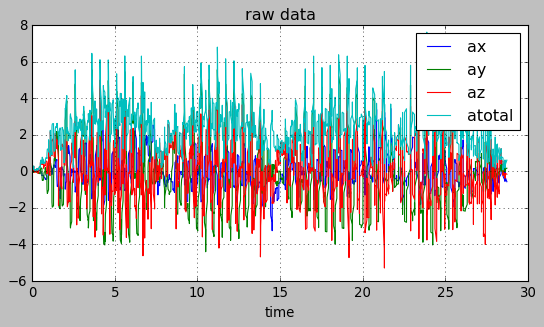

In [44]:
data_update = df[df['Subject'].isin(file_paths_uri)]

subjects = df['Subject']
folders = [folder_path+'/'+str(c) for c in subjects.values]
d = pd.read_csv(folders[2]+".csv").set_index('time')
d.iloc[:,:4].plot()
plt.title('raw data');

In [45]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def fetch(subjects, df, freq=128, n_seconds=3, train=False):
    """
    A function to read subjects accelerometer data.

    params:
        subjects : a list of subjects folders
        freq     : the sampling frequency all signals will be converted to
        n_seconds: number of seconds to fetch from each signal
        train    : if true, fetches two n_seconds signals from each recording, as data augmentation. default: False

    """

    output = pd.DataFrame()  # output dataframe
    num_index = 0  # Initialize num_index outside the loop
    # for each subject, try to read accelerometer data
    for s in tqdm(subjects):
        try:
            data = pd.read_csv(s + '.csv')
            data.columns = ['time', 'x', 'y', 'z', 't']
        except:
            print(s, ':\t', sys.exc_info()[0])
            continue

        # remove very short recordings
        if data['time'].max() < 12:
            print(f'Too short dataset {s}: {data["time"].max()}')
            continue

        # data cleaning: if accelerometer is turned off, remove following data.
        off_phase = np.where(np.diff(data.time) > 1)[0]
        if off_phase.shape[0] > 0:
            data = data.loc[:off_phase[0]]

        # calculate sampling frequency for each subject
        fs = data.time.idxmax() / data.time.max()

        data.set_index('time', inplace=True)

        # take n_seconds measurements. we take n_seconds around the first quarter, as the middle point is
        # often when the person turned back.
        if train:
            n_seconds *= 2
        middle = data.index.max() / 4
        start = middle - n_seconds / 2
        end = middle + n_seconds / 2
        data = data[(data.index > start) & (data.index < end)]

        # up/down sample to <freq> hz
        x = data.index
        xnew = np.linspace(min(x), max(x), freq * n_seconds)
        for c in data.columns:
            y = data[c]
            f = interpolate.interp1d(x, y, bounds_error=False, fill_value="extrapolate")
            ynew = f(xnew)
            temp = pd.DataFrame(ynew.reshape(1, -1))

            temp['Subject'] = df.iloc[num_index]['Subject']
            temp['Axis'] = c
            output = output.append(temp, ignore_index=True)

        num_index += 1  # Increment num_index for each subject

    # Merge with additional information from df
    output = output.merge(df, how='left', on='Subject')

    # Reorder columns
    output = output[['Subject', 'Age','Gender', 'vig',	'mod', 'walk',	'IPAQ_activity',	'IPAQ_sitting', 'BriefBESTest', 'height',	'weight', 'bmi', 'Axis'] + list(range(freq * n_seconds))]

    return output

In [46]:
# call the fetch function to read data
n_seconds = 8
newfreq = 100

data = fetch(folders,df, freq = newfreq, n_seconds = n_seconds)

  0%|          | 0/27 [00:00<?, ?it/s]

In [47]:
handcrafted_features = pd.DataFrame()
signal_col = data.iloc[:, 13:]
# Maximum
handcrafted_features['maximum'] = signal_col.max(axis=1)

# Minimum
handcrafted_features['minimum'] =signal_col.min(axis=1)

# Average
handcrafted_features['average'] = signal_col.mean(axis=1)

# Standard deviation
handcrafted_features['std'] = signal_col.std(axis=1)

# Zero crossing
def zero_crossings(values):
    count = 0
    prev_value = values[0]

    # Iterate over the values starting from the second value
    for value in values[1:]:
        # Check if the sign of the current value is different from the previous value
        if prev_value * value < 0:
            count += 1  # Increment the count if there is a zero crossing
        prev_value = value  # Update the previous value for the next iteration

    return count
handcrafted_features['zero_crossings'] = signal_col.apply(zero_crossings, axis=1)

# Percentiles
handcrafted_features['percentile_20'] =signal_col.quantile(0.20, axis=1)
handcrafted_features['percentile_50'] = signal_col.quantile(0.50, axis=1)
handcrafted_features['percentile_80'] = signal_col.quantile(0.80, axis=1)

# Interquartile range
handcrafted_features['interquartile_range'] = signal_col.quantile(0.75, axis=1) - data.iloc[:, 7:807].quantile(0.25, axis=1)

# Kurtosis
handcrafted_features['kurtosis'] = signal_col.kurtosis(axis=1)

# Skewness   𝑠𝑘𝑒𝑤𝑛𝑒𝑠𝑠(𝑀)= 𝜇˜**3= ∑𝑛𝑖=1(𝑚𝑖−𝜇)**3/𝑛𝜎3
handcrafted_features['skewness'] =signal_col.skew(axis=1)

# Order mean values
def order_mean_values(row):
    sorted_row = np.sort(row)  # Sort the row in ascending order
    fom = sorted_row[0]  # First-order statistic (smallest value)
    som = np.mean(sorted_row[:2])  # Second-order statistic (mean of the two smallest values)
    som = np.reshape(som, (1,))  # Reshape som into a 1D array

    # Compute norms
    norm_fom_l1 = np.linalg.norm(sorted_row, ord=1)  # L1 norm of FOM
    norm_fom_l2 = np.linalg.norm(sorted_row, ord=2)  # L2 norm of FOM
    norm_som_l1 = np.linalg.norm(som, ord=1)  # L1 norm of SOM
    norm_som_l2 = np.linalg.norm(som, ord=2)  # L2 norm of SOM
    som = np.mean(sorted_row[:2])  # Second-order statistic (mean of the two smallest values)
    som = np.reshape(som, (1,))[0]
    return [fom, som, norm_fom_l1, norm_fom_l2, norm_som_l1, norm_som_l2]

handcrafted_features[['FOM', 'SOM', 'Norm_FOM_L1', 'Norm_FOM_L2', 'Norm_SOM_L1', 'Norm_SOM_L2']] = signal_col.apply(order_mean_values, axis=1, result_type='expand')

# Spectral entropy  &  Spectral energy:
def spectral_features(row):
    fft_values = np.fft.fft(row) # Compute the Fourier transform
    power_spectrum = np.abs(fft_values) ** 2  # Compute the power spectrum
    normalized_power = power_spectrum / np.sum(power_spectrum)  # Normalize the power distribution
    spectral_entropy = -np.sum(normalized_power * np.log2(normalized_power)) # Compute Shannon entropy
    spectral_energy = np.sum(power_spectrum)    # Compute the Spectral Energ
    return [spectral_energy, spectral_entropy]

handcrafted_features[['Spectral_Energy', 'Spectral_Entropy']] = signal_col.apply(spectral_features, axis=1, result_type='expand')

# Auto-correlation 𝑅𝑘=  (∑𝑛−𝑘𝑖=1(𝑚𝑖−𝜇)(𝑚𝑖+𝑘−𝜇))/(∑𝑛𝑖=1(𝑚𝑖−𝜇)2)
def auto_correlation(data):
    # Select the columns of interest (columns 6 onwards)
    # Convert the DataFrame to a numpy array, handle missing values, and ensure numeric values
    signal_values = data.to_numpy(dtype=float)  # Convert to numpy array
    signal_values[np.isnan(signal_values)] = 0  # Handle missing values by replacing with 0

    # Compute auto-correlation for each row in the DataFrame
    auto_corr_values = []
    for row in signal_values:
        auto_corr = np.correlate(row, row, mode='full')
        positive_auto_corr = auto_corr[len(row) - 1:]  # Extract positive auto-correlation values
        auto_corr_values.append(positive_auto_corr)
    return auto_corr_values
auto_corr_values = auto_correlation(signal_col)
auto_corr_df = pd.DataFrame(auto_corr_values, columns=[f'auto_corr_{i}' for i in range(len(auto_corr_values[0]))])

base_feature= data.loc[:,['Subject', 'Age','Gender', 'vig',	'mod', 'walk',	'IPAQ_activity',	'IPAQ_sitting', 'BriefBESTest', 'height',	'weight', 'bmi']]
# Concatenate handcrafted features with the existing DataFrame
data = pd.concat([data , auto_corr_df, handcrafted_features], axis=1)

In [48]:
data.to_csv(path+'output_file/data_new.csv')